#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# Оглавление<a name="Оглавление"></a>

- 1. [Подготовка](#Подготовка)
  - 1.1. [Загружаем данные](#Загружаем)
  - 1.2. [Ресемплируем данные по 1 часу](#Ресемплируем)
  - 1.3. [Вывод по подготовке данных](#Вывод)
- 2. [Анализ](#Анализ)
  - 2.1. [Добавить столбец 'rolling_mean' - скользящее среднее с размером окна, равным 10](#Добавить)
  - 2.2. [Разложение временного ряда на тренд, сезонность и остаток](#Разложение)
  - 2.3. [Вывод по анализу данных](#Вывод_по)
- 3. [Обучение](#Обучение)
  - 3.1. [Создание признаков для обучения моделей](#Создание)
  - 3.2. [Разделим данные на обучающую и тестовую выборки](#Разделим)
  - 3.3. [Подготовка выборок и выделение признаков и целевых признаков](#Подготовка)
  - 3.4. [Поиск гиперпараметров](#Поиск)
    - 3.4.1. [LinearRegression](#LinearRegression)
    - 3.4.2. [DecisionTreeRegressor](#DecisionTreeRegressor)
    - 3.4.2. [CatBoostRegressor](#CatBoostRegressor)
    - 3.4.2. [LGBMRegressor](#LGBMRegressor)
- 4. [Сравнение моделей](#Сравнение)
     - 4.0.1. [LinearRegression](#LinearRegression_)
     - 4.0.2. [DecisionTreeRegressor](#DecisionTreeRegressor_)
     - 4.0.3. [CatBoostRegressor](#CatBoostRegressor_)
     - 4.0.4. [LGBMRegressor](#LGBMRegressor_)
  - 4.1. [Выполнение задачи](#Выполнение)
- 5. [Тестирование](#Тестирование)
- 6. [Общий вывод](#Общий)

## 1. Подготовка<a name="Подготовка"></a>

### 1.1. Загружаем данные<a name="Загружаем"></a>

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('./datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
print('Количество явных дубликтов:', df.duplicated().sum())
df.info()
df.head(5)

Количество явных дубликтов: 26415
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.sort_index(inplace=True)

In [5]:
df.index.is_monotonic

True

[К оглавлению](#Оглавление)

### 1.2. Ресемплируем данные по 1 часу<a name="Ресемплируем"></a>

<AxesSubplot:xlabel='datetime'>

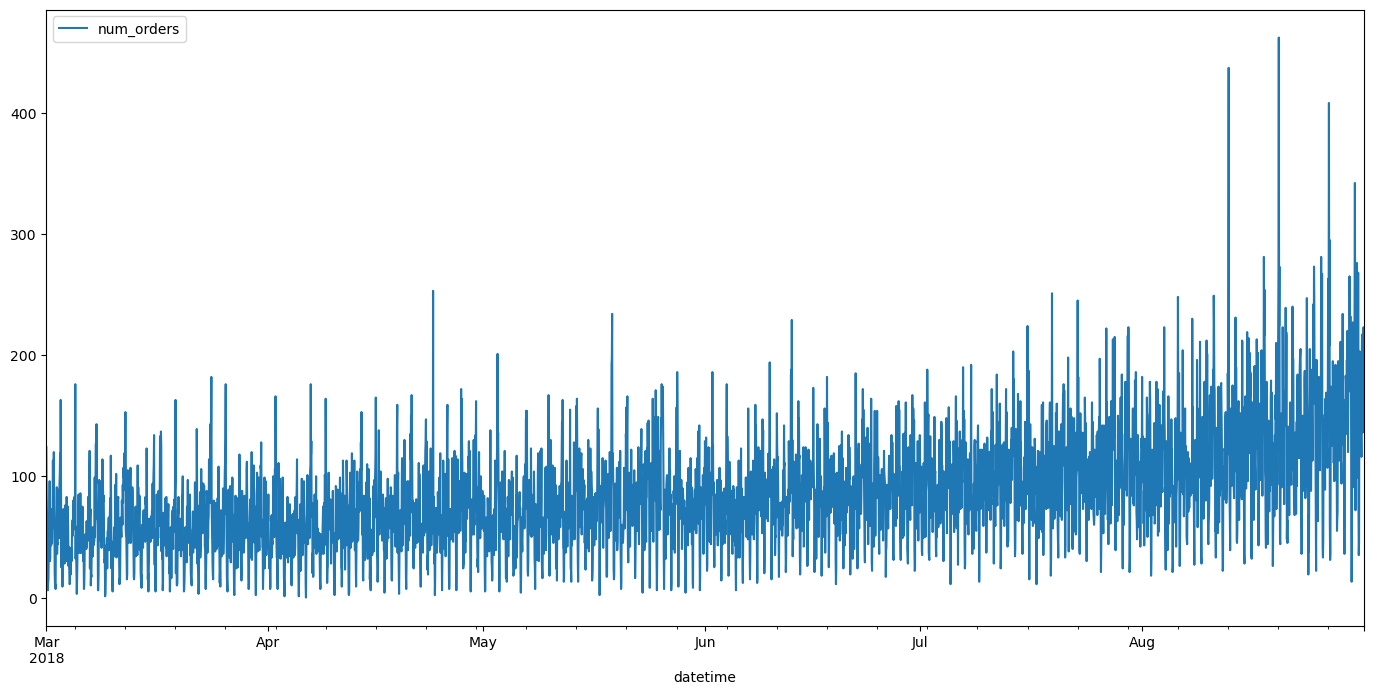

In [6]:
df = df.resample('1H').sum()
df.plot(figsize = (17,8))

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


[К оглавлению](#Оглавление)

### 1.3. Вывод по подготовке данных<a name="Вывод"></a>
- Данные получены, открыты с распознаванием дат и формированием новых индексов
- Поизведена сортировка данных в порядке хронологическом порядке от старых к новым
- Произведён ресемплинг по суммарным значениям за час

## 2. Анализ<a name="Анализ"></a>

### 2.1. Добавить столбец 'rolling_mean' - скользящее среднее с размером окна, равным 10<a name="Добавить"></a>

In [8]:
df1 = df.copy()
df1['rolling_mean'] = df.rolling(10).mean()

<AxesSubplot:xlabel='datetime'>

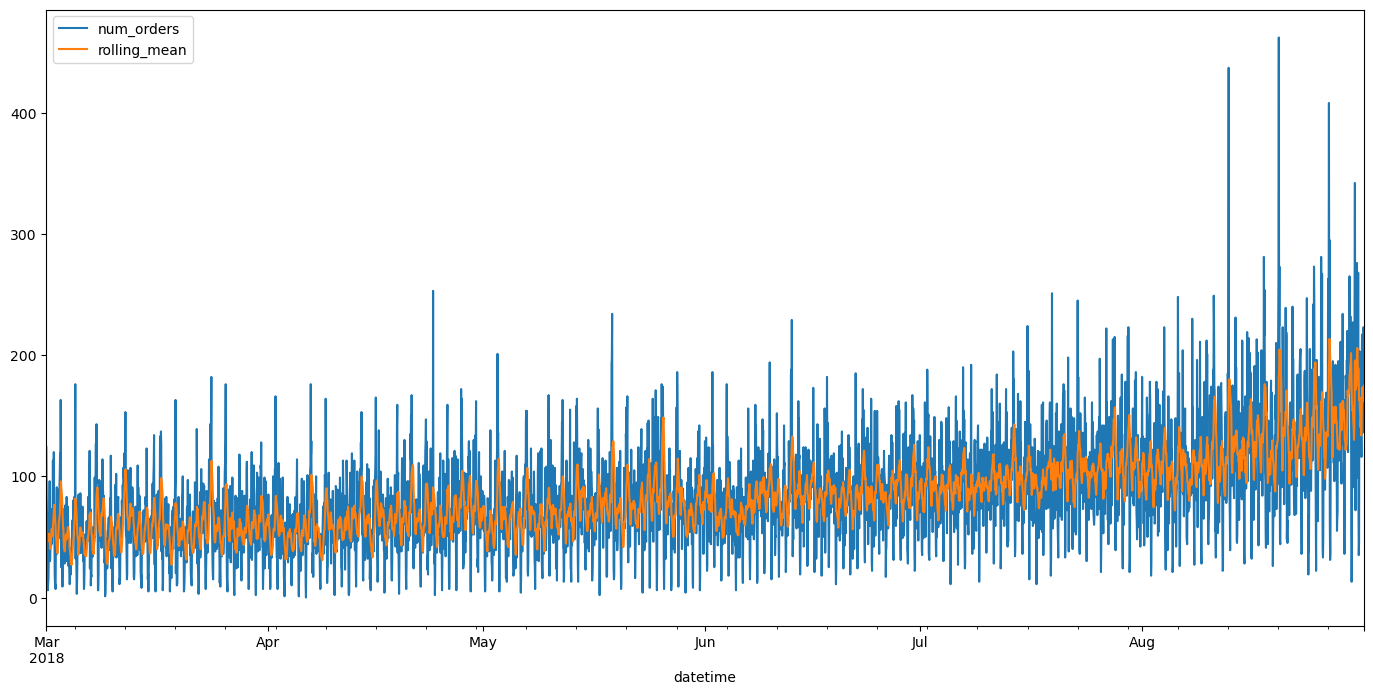

In [9]:
df1.plot(figsize = (17,8))

<AxesSubplot:xlabel='datetime'>

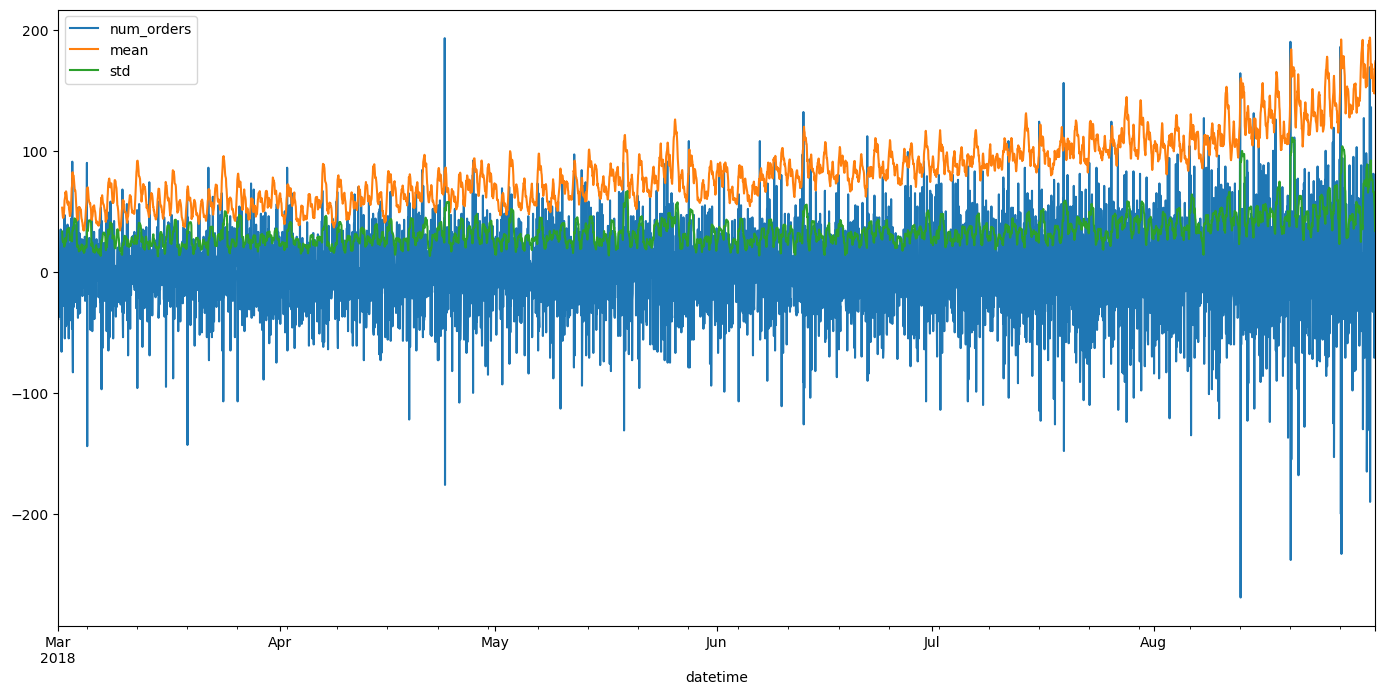

In [10]:
df1 = df - df.shift()
df1['mean'] = df.rolling(15).mean()
df1['std'] = df.rolling(15).std()
df1.plot(figsize = (17,8))

[К оглавлению](#Оглавление)

### 2.2. Разложение временного ряда на тренд, сезонность и остаток<a name="Разложение"></a>

In [11]:
decomposed = seasonal_decompose(df)

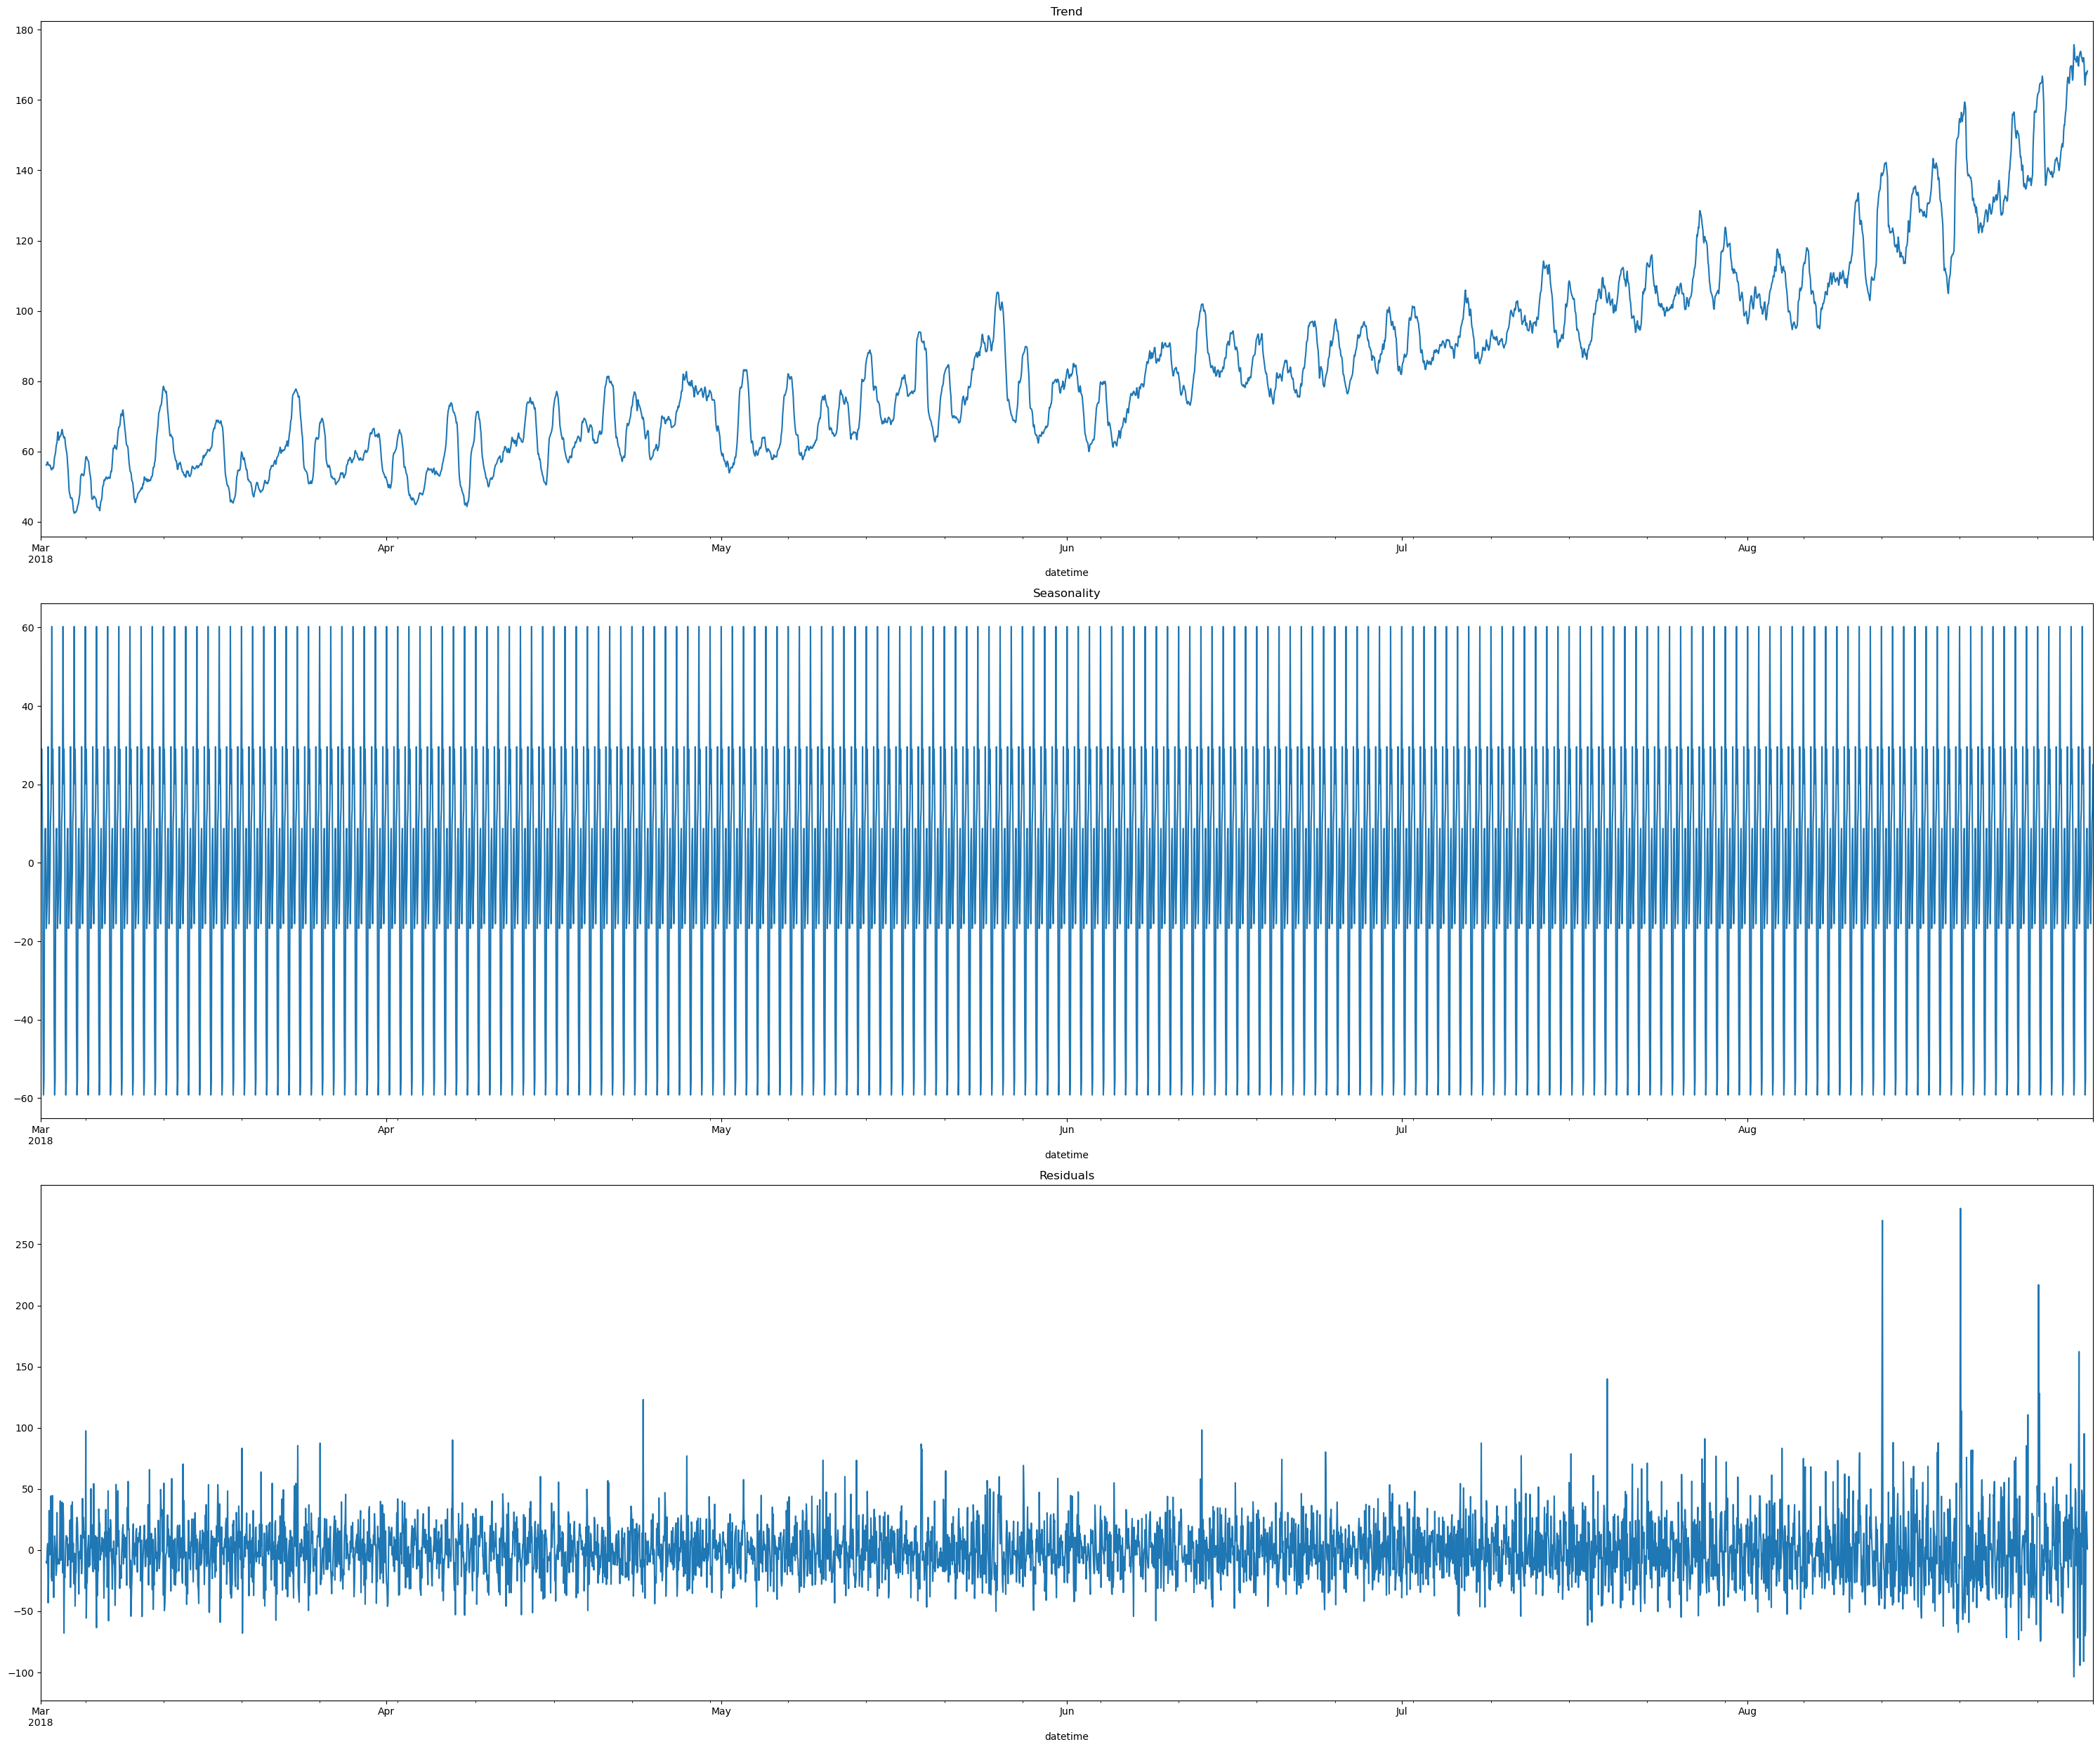

In [12]:
plt.figure(figsize=(30, 25))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд - восходящий, видимо поездки за исследуемый период только увеличивались. Временной ряд не стационарный - у него меняется среднее значение.

Сезонность пока не понять. Посмотрим более детально но в разрезе одной недели в начале и в конце анализируемого периода.

По графику тренда заметно, что к концу лета количество заказов в час увеличилось.

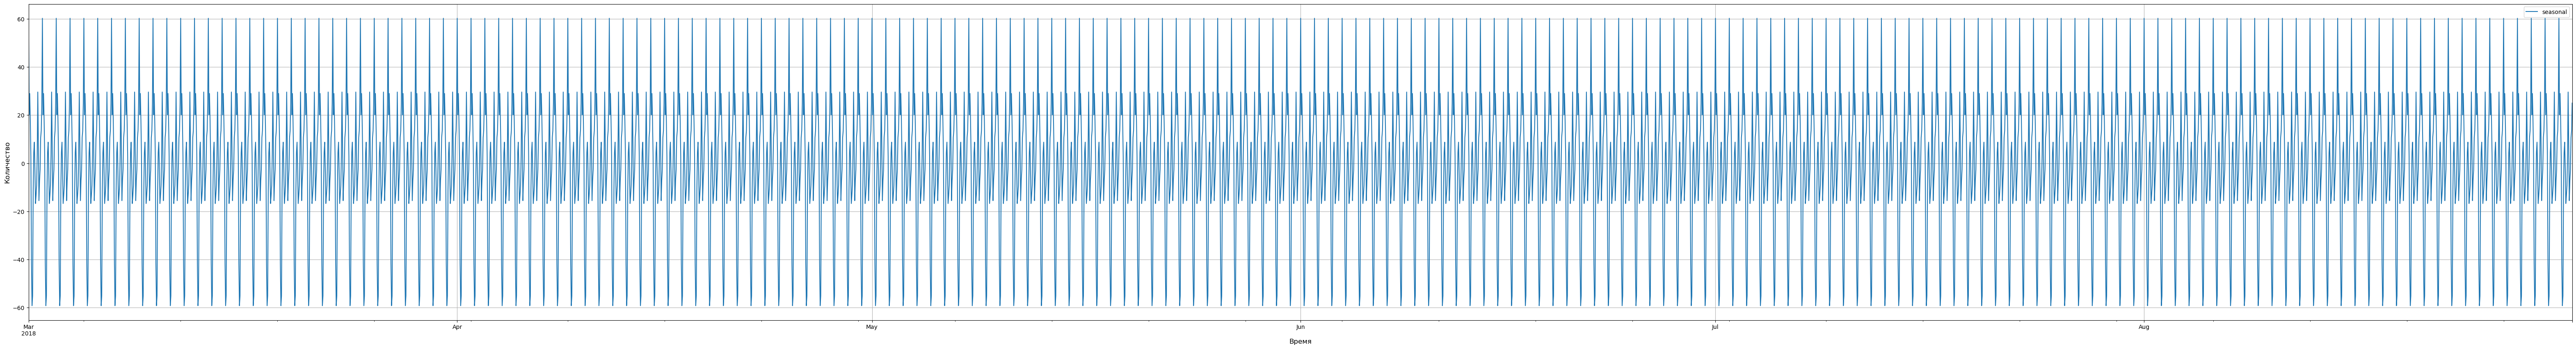

In [13]:
plt.figure(figsize=(80, 10))
decomposed.seasonal.plot(ax=plt.gca())
plt.xlabel('Время', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.grid()
plt.legend()
plt.show()

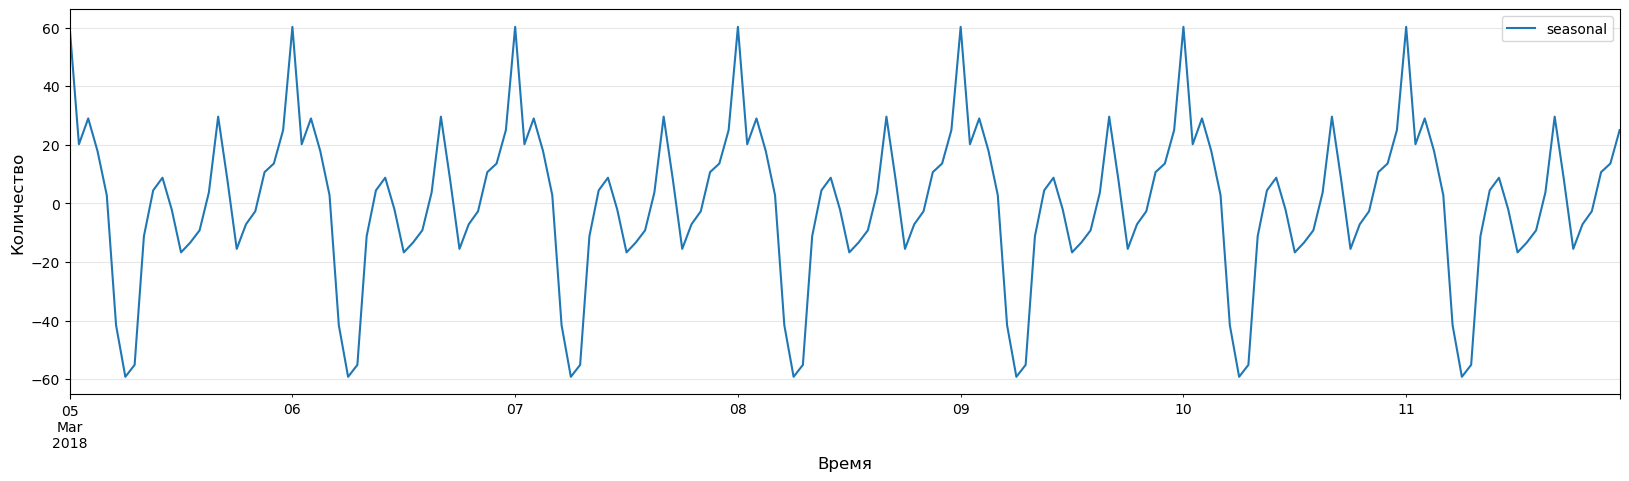

In [14]:
plt.figure(figsize=(20, 5))
decomposed.seasonal['2018-03-05':'2018-03-11'].plot(ax=plt.gca())
plt.xlabel('Время', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.grid(axis='y', alpha=.3)
plt.legend()
plt.show()

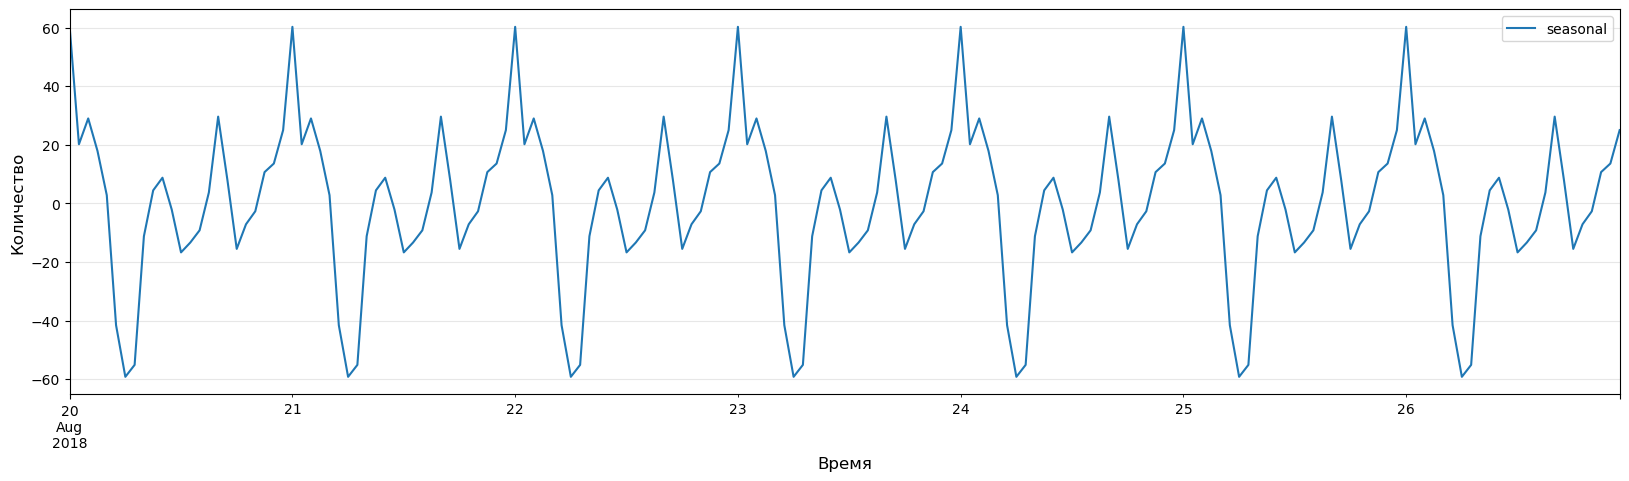

In [15]:
plt.figure(figsize=(20, 5))
decomposed.seasonal['2018-08-20':'2018-08-26'].plot(ax=plt.gca())
plt.xlabel('Время', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.grid(axis='y', alpha=.3)
plt.legend()
plt.show()

[К оглавлению](#Оглавление)

### 2.3. Вывод по анализу данных<a name="Вывод_по"></a>
Анализ графиков составляющих времененного ряда с помощью разложения его на три составляющих позволяет обнаружить восходящей тренд с явно выраженной внутрисуточной сезонностью, которая повторяется каждый день. Наибольшее число заказов приходится на вечер, а меньше всего заказов после полуночи и ближе к утру. Сезонность по месяцам (весной и летом) и дням (понедельник и пятница) не наблюдается. Рассматриваемый временной ряд относится к числу нестационарных по тренду, потому что у него меняется среднее значение со временем.

## 3. Обучение<a name="Обучение"></a>

### 3.1. Создание признаков для обучения моделей<a name="Создание"></a>

In [17]:
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 500, 300)

In [18]:
df.shape

(4416, 506)

In [19]:
df.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_492,lag_493,lag_494,lag_495,lag_496,lag_497,lag_498,lag_499,lag_500,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[К оглавлению](#Оглавление)

### 3.2. Разделим данные на обучающую и тестовую выборки<a name="Разделим"></a>

In [20]:
make_features(df, 2, 10)

In [21]:
train_full, test = train_test_split(df, shuffle=False, test_size=.1)
train, valid = train_test_split(train_full, shuffle=False, test_size=.2)
train = train.dropna()
test.shape, valid.shape, train.shape

((442, 506), (795, 506), (2679, 506))

In [22]:
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid[['num_orders']]

In [23]:
features_train  = train.drop('num_orders', axis=1)
target_train = train[['num_orders']]
features_test = test.drop('num_orders', axis=1)
target_test = test[['num_orders']]

[К оглавлению](#Оглавление)

### 3.3. Подготовка выборок и выделение признаков и целевых признаков<a name="Подготовка"></a>

Мы будем использовать 4 модели:

- LinearRegression;
- DecisionTreeRegressor;
- CatBoostRegressor;
- LGBMRegressor.

Из них выберем лучшую по критерию лучшего показателя и времени обучения.

Напишем функцию rmse

In [24]:
def rmse(y, predictions):
    return mse(y, predictions) ** .5

rmse_score = make_scorer(rmse, greater_is_better=False)

In [25]:
scaler = StandardScaler()

X_train = scaler.fit_transform(features_train)
X_test = scaler.transform(features_test)
X_train_norm = features_train
X_test_norm = features_test
y_train = target_train
y_test = target_test

In [26]:
X_train.shape

(2679, 505)

In [27]:
X_test.shape

(442, 505)

In [28]:
features_valid.shape

(795, 505)

[К оглавлению](#Оглавление)

### 3.4. Поиск гиперпараметров<a name="Поиск"></a>

#### 3.4.1. LinearRegression<a name="LinearRegression"></a>

In [29]:
%%time
state = 42
tscv = TimeSeriesSplit(n_splits=8)
model = LinearRegression()
    

param_dict = {'fit_intercept':[True, False],
                    'copy_X':[True, False]}

griddlr = GridSearchCV(model, param_dict, cv = tscv, scoring='neg_mean_squared_error', n_jobs = -1)
griddlr.fit(X_train, y_train)
griddlr.best_score_

Wall time: 4.11 s


-743.373393133493

In [30]:
print(griddlr.best_estimator_)
print()
print(griddlr.best_params_)
print()
print(griddlr.best_score_)

LinearRegression()

{'copy_X': True, 'fit_intercept': True}

-743.373393133493


[К оглавлению](#Оглавление)

#### 3.4.2. DecisionTreeRegressor<a name="DecisionTreeRegressor"></a>

In [31]:
%%time
state = 42
tscv = TimeSeriesSplit(n_splits=8)
model = DecisionTreeRegressor(random_state=state)
    

param_dict = {'max_depth': range(1, 8),
              'min_samples_leaf' : range (1,6),
              'max_features' : range(1,7)}

griddtr = GridSearchCV(model, param_dict, cv=tscv, scoring='neg_mean_squared_error', n_jobs = -1)

griddtr.fit(features_train, target_train)
griddtr.best_score_

Wall time: 7.7 s


-722.7337967085791

In [32]:
print(griddtr.best_estimator_)
print()
print(griddtr.best_params_)
print()
print(griddtr.best_score_)

DecisionTreeRegressor(max_depth=4, max_features=6, min_samples_leaf=5,
                      random_state=42)

{'max_depth': 4, 'max_features': 6, 'min_samples_leaf': 5}

-722.7337967085791


[К оглавлению](#Оглавление)

#### 3.4.3. CatBoostRegressor<a name="CatBoostRegressor"></a>

In [33]:
model = CatBoostRegressor() 
tscv = TimeSeriesSplit(n_splits=8)
param_dict = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[42],
                'verbose':[False]}]

print()
gridcb = GridSearchCV(model, param_dict, cv = tscv,scoring='neg_mean_squared_error')
gridcb.fit(features_train, target_train)
gridcb.best_score_

-422.9291767715943

In [34]:
%%time
print(gridcb.best_estimator_)
print()
print(gridcb.best_params_)
print()
print(gridcb.best_score_)


{'learning_rate': 0.1, 'random_state': 42, 'verbose': False}

-422.9291767715943
Wall time: 0 ns


[К оглавлению](#Оглавление)

#### 3.4.4. LGBMRegressor<a name="LGBMRegressor"></a>

In [35]:
model = LGBMRegressor() 
tscv = TimeSeriesSplit(n_splits=8)
param_dict = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[42]
             }]
print()
gridlgmr = GridSearchCV(model, param_dict, cv = tscv,scoring='neg_mean_squared_error',n_jobs = -1)
gridlgmr.fit(features_train, target_train)
gridlgmr.best_score_


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81263
[LightGBM] [Info] Number of data points in the train set: 2679, number of used features: 504
[LightGBM] [Info] Start training from score 74.096678


-424.76818636577275

In [36]:
%%time
print(gridlgmr.best_estimator_)
print()
print(gridlgmr.best_params_)
print()
print(gridlgmr.best_score_)

LGBMRegressor(random_state=42)

{'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 42}

-424.76818636577275
Wall time: 1 ms


[К оглавлению](#Оглавление)

## 4. Сравнение моделей<a name="Сравнение"></a>

#### 4.0.1 LinearRegression На не стандартизированной выборке<a name="LinearRegression_"></a>

In [37]:
model2 = LinearRegression(copy_X = True,
                          fit_intercept = True) 
start = time.time()
model2.fit(features_train, target_train) 
fit_time2 = time.time() - start
predictions_2 = model2.predict(features_valid) 
pred_time2 = time.time() - start
result2 = rmse(target_valid,predictions_2)


print('LinearRegression: ', result2)
print("Время обучения: ", fit_time2)
print("Время предсказания: ", pred_time2)

LinearRegression:  28.088617675565796
Время обучения:  0.07509088516235352
Время предсказания:  0.0813760757446289


[К оглавлению](#Оглавление)

#### 4.0.2. DecisionTreeRegressor<a name="DecisionTreeRegressor_"></a>

In [38]:
model3 = DecisionTreeRegressor(random_state=42,
                               max_depth =4, 
                               max_features=6,
                               min_samples_leaf=1) 
start = time.time()
model3.fit(features_train, target_train) 
fit_time3 = time.time() - start
predictions_3 = model3.predict(features_valid) 
pred_time3 = time.time() - start
result3 = rmse(target_valid,predictions_3)


print('DecisionTreeRegressor: ', result3)
print("Время обучения: ", fit_time3)
print("Время предсказания: ", pred_time3)

DecisionTreeRegressor:  37.90723685526985
Время обучения:  0.01450657844543457
Время предсказания:  0.020528316497802734


[К оглавлению](#Оглавление)

#### 4.0.3. CatBoostRegressor<a name="CatBoostRegressor_"></a>

In [39]:
model4 = CatBoostRegressor(learning_rate = 0.1,
                           random_state = 42,
                           verbose = False) 
start = time.time()
model4.fit(features_train, target_train) 
fit_time4 = time.time() - start
predictions_4 = model4.predict(features_valid) 
pred_time4 = time.time() - start
result4 = rmse(target_valid,predictions_4)


print("CatBoostRegressor", result4)
print("Время обучения: ", fit_time4)
print("Время предсказания: ", pred_time4)

CatBoostRegressor 28.375150841804977
Время обучения:  25.657037496566772
Время предсказания:  25.673238515853882


[К оглавлению](#Оглавление)

#### 4.0.4. LGBMRegressor<a name="LGBMRegressor_"></a>

In [40]:
model5 = LGBMRegressor(learning_rate= 0.1,
                       num_leaves=31,
                       random_state= 42,
                      boosting_type='gbdt') 
start = time.time()
model5.fit(features_train, target_train) 
fit_time5 = time.time() - start
predictions_5 = model5.predict(features_valid) 
pred_time5 = time.time() - start
result5 = rmse(target_valid,predictions_5)


print('LGBMRegressor: ', result5)
print("Время обучения: ", fit_time5)
print("Время предсказания: ", pred_time5)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81263
[LightGBM] [Info] Number of data points in the train set: 2679, number of used features: 504
[LightGBM] [Info] Start training from score 74.096678
LGBMRegressor:  28.460568405493483
Время обучения:  0.7632272243499756
Время предсказания:  0.7702748775482178


[К оглавлению](#Оглавление)

### 4.1. Выполнение задачи<a name="Выполнение"></a>

In [41]:
index = ['LinearRegression',
         'DecisionTreeRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']
data = {'Время обучения':[fit_time2,
                         fit_time3,
                         fit_time4,
                         fit_time5],
        'Время предсказания':[pred_time2,
                             pred_time3,
                             pred_time4,
                             pred_time5],
        'RMSE':[result2,
               result3,
               result4,
               result5]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['RMSE'] < 48.0
scores_data

,Время обучения,Время предсказания,RMSE,Выполнение задачи
LinearRegression,0.075091,0.081376,28.088618,True
DecisionTreeRegressor,0.014507,0.020528,37.907237,True
CatBoostRegressor,25.657037,25.673239,28.375151,True
LGBMRegressor,0.763227,0.770275,28.460568,True


[К оглавлению](#Оглавление)

## 5. Тестирование<a name="Тестирование"></a>

Для тестирования выбрана модель LinearRegression	

In [42]:
train_full = train.dropna()
features_train_full = train_full.drop(['num_orders'], axis=1)
target_train_full = train_full[['num_orders']]

In [43]:
model2 = LinearRegression(copy_X = True,
                          fit_intercept = True) 
start = time.time()
model2.fit(features_train_full, target_train_full) 
fit_time2 = time.time() - start
predictions_2 = model2.predict(features_test) 
pred_time2 = time.time() - start
result2 = rmse(target_test,predictions_2)


print('LinearRegression: ', result2)
print("Время обучения: ", fit_time2)
print("Время предсказания: ", pred_time2)

LinearRegression:  43.72240885468702
Время обучения:  0.0683286190032959
Время предсказания:  0.07283210754394531


[К оглавлению](#Оглавление)

## 6. Общий вывод<a name="Общий"></a>

В ходе исследования выполены следующие действия:

- Данные получены, открыты с распознаванием дат и формированием новых индексов.
- Поизведена сортировка данных в порядке хронологическом порядке от старых к новым. 
- Произведён ресемплинг по суммарным значениям за час.
- Созданы дополнительные признаки из разбиения дат, "отстающих значений", и скользящего среднего.
- Данные подготовлены для обучения моделей.

В исследовании участвовали четыре модели:
- LinearRegression;
- DecisionTreeRegressor;
- CatBoostRegressor;
- LGBMRegressor.

Для каждой были подобраны гиперпараметры, при помощи GridSearchCV, а также кросс-валидатора временных рядом TimeSeriesSplit.

После модели были обучены и предсказали значения из тестовой выборки. Лучшие значения показала модель LinearRegression с показателем 43,72.